In [974]:
import math

import pandas as pd

In [975]:
"""
Max colour input value - TODO (use for fixed max_diff algorithms)
(max value most likely needs to be manually capped to some value - looks like 1000 works best atm)

Average colour values (from collected data in the csvs):

Right sensor:
Red:
R - 810
G - 190
B - 140
Wood:
R - 900
G - 700
B - 320

Left sensor:
Red:
R - 750
G - 170
B - 140
Wood:
R - 800
G - 600
B - 300
"""

MAX_STEER = 100.0
MAX_LF_STEER = 1.0  # max fraction of MAX_STEER that it will do while line following

N = 100  # number of data points in normalized datasets

R_R_R = 810  # calibrated "red" values for right sensor
G_R_R = 190
B_R_R = 140

R_W_R = 900  # calibrated "wood" values for right sensor
G_W_R = 700
B_W_R = 320

R_R_L = 750  # calibrated "red" values for left sensor
G_R_L = 170
B_R_L = 140

R_W_L = 800  # calibrated "wood" values for left sensor
G_W_L = 600
B_W_L = 300

In [976]:
# RGB weighted delta algorithm
# works pretty well, good fit to ideal after training
# weights after training: [-14.305698059837928, 25.892144036014848, -0.31817949308214466, -10.448841398546417, 22.19892318209062, -0.0835868857881632]
# error after training: 7.667551641821958
# weights: [r_w_l, g_w_l, b_w_l, r_w_r, g_w_r, b_w_r]
TRAIN_ITERATIONS = 200
TRAIN_STEP = 0.5
MAX_READING = 1000
weights = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
def lf_algorithm(weights, r_l, g_l, b_l, r_r, g_r, b_r):
    L_notred = abs(
        (weights[0] * (r_l - R_R_L))
        + (weights[1] * (g_l - G_R_L))
        + (weights[2] * (b_l - B_R_L))
    )
    R_notred = abs(
        (weights[3] * (r_r - R_R_R))
        + (weights[4] * (g_r - G_R_R))
        + (weights[5] * (b_r - B_R_R))
    )
    delta = L_notred - R_notred
    max_delta = max((weights[0] + weights[1] + weights[2]), (weights[3] + weights[4] + weights[5])) * MAX_READING
    steer = ((MAX_STEER * MAX_LF_STEER) / max_delta) * delta
    return steer

In [977]:
# # green-only weighted delta algorithm
# # untrainable, function of this nature can't fit the ideal with training
# # error after training: 23.957909948109286
# # weights: [g_w_l, g_w_r]
# TRAIN_ITERATIONS = 200
# TRAIN_STEP = 0.5
# MAX_READING = 1000
# weights = [1.0, 1.0]
# def lf_algorithm(weights, r_l, g_l, b_l, r_r, g_r, b_r):
#     L_notred = abs(weights[0] * (g_l - G_R_L))
#     R_notred = abs(weights[1] * (g_r - G_R_R))
#     delta = L_notred - R_notred
#     max_delta = max(weights) * MAX_READING
#     steer = ((MAX_STEER * MAX_LF_STEER) / max_delta) * delta
#     return steer

In [978]:
# # fixed steer after RGB threshold algorithm
# # no training needed, hard-coded to follow ideal case as well as it can
# TRAIN_ITERATIONS = 0
# TRAIN_STEP = 1
# MAX_READING = 1000
# weights = [3.0]
# def lf_algorithm(weights, r_l, g_l, b_l, r_r, g_r, b_r):
#     steer = 0
#     if (r_l < weights[0] * R_R_L) and (g_l < weights[0] * G_R_L) and (b_l < weights[0] * B_R_L):
#         steer = -50
#     elif (r_r < weights[0] * R_R_R) and (g_r < weights[0] * G_R_R) and (b_r < weights[0] * B_R_R):
#         steer = 50
#     return steer

In [979]:
def lf_algorithm_steers(weights, l_df, r_df):
    steers = []
    for i in range(N):
        steers.append(
            lf_algorithm(
                weights,
                l_df.loc[i, "R"],
                l_df.loc[i, "G"],
                l_df.loc[i, "B"],
                r_df.loc[i, "R"],
                r_df.loc[i, "G"],
                r_df.loc[i, "B"],
            )
        )
    return steers

In [980]:
def input_data():
    r_r = []
    g_r = []
    b_r = []
    r_l = []
    g_l = []
    b_l = []

    for i in range(N):
        r_r.append(R_R_R + ((R_W_R - R_R_R) / (1 + math.exp(-1 * ((1 / 4) * i - 5)))))
        g_r.append(G_R_R + ((G_W_R - G_R_R) / (1 + math.exp(-1 * ((1 / 4) * i - 5)))))
        b_r.append(B_R_R + ((B_W_R - B_R_R) / (1 + math.exp(-1 * ((1 / 4) * i - 5)))))
        r_l.append(R_W_L + (-1 * (R_W_L - R_R_L) / (1 + math.exp(-1 * ((1 / 4) * i - 20)))))
        g_l.append(G_W_L + (-1 * (G_W_L - G_R_L) / (1 + math.exp(-1 * ((1 / 4) * i - 20)))))
        b_l.append(B_W_L + (-1 * (B_W_L - B_R_L) / (1 + math.exp(-1 * ((1 / 4) * i - 20)))))

    return [
        pd.DataFrame({"R": r_r, "G": g_r, "B": b_r}),
        pd.DataFrame({"R": r_l, "G": g_l, "B": b_l}),
    ]

In [981]:
def ideal_steer():
    steers = []
    for i in range(0, math.ceil(0.8 * (N / 2))):
        steers.append(
            (MAX_STEER * MAX_LF_STEER)
            * (math.floor(0.8 * (N / 2)) - i)
            / math.floor(0.8 * (N / 2))
        )
    for i in range(math.ceil(0.8 * (N / 2)), math.ceil(1.2 * (N / 2))):
        steers.append(0)
    for i in range(math.ceil(1.2 * (N / 2)), N):
        steers.append(
            -1
            * (MAX_STEER * MAX_LF_STEER)
            * (i - math.ceil(1.2 * (N / 2)))
            / (N - math.ceil(1.2 * (N / 2)))
        )
    steers.remove(0.0)
    steers.append(-100.0)
    return steers

In [982]:
def error(actual, ideal):
    total_e = 0.0
    for i in range(N):
        total_e += abs(actual[i] - ideal[i])
    return total_e / N

In [983]:
def calc_gradient(weights, l_df, r_df, linear):
    weights_copy = weights.copy()
    gradient = [0.0 for _ in range(len(weights))]
    for i in range(len(weights_copy)):
        # increase weight, calculate derror/dwi based on amount error changes
        e_before = error(lf_algorithm_steers(weights_copy, l_df, r_df), linear)
        weights_copy[i] += TRAIN_STEP
        e_after = error(lf_algorithm_steers(weights_copy, l_df, r_df), linear)
        weights_copy[i] -= TRAIN_STEP
        gradient[i] = ((e_before - e_after) / TRAIN_STEP)

        # if error increased, check if decreasing weight actually decreases error
        if gradient[i] < 0:
            e_before = error(lf_algorithm_steers(weights_copy, l_df, r_df), linear)
            weights_copy[i] -= TRAIN_STEP
            e_after = error(lf_algorithm_steers(weights_copy, l_df, r_df), linear)
            weights_copy[i] += TRAIN_STEP
            # if changing weight in either direction increases error, set gradient = 0
            if e_after > e_before:
                gradient[i] = 0
    return gradient

Weights before training: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Error before training: 32.487073766305286
Weights after training: [-14.305698059837928, 25.892144036014848, -0.31817949308214466, -10.448841398546417, 22.19892318209062, -0.0835868857881632]
Error after training: 7.667551641821958


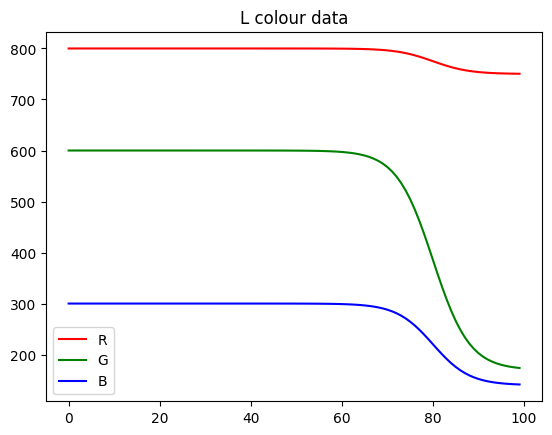

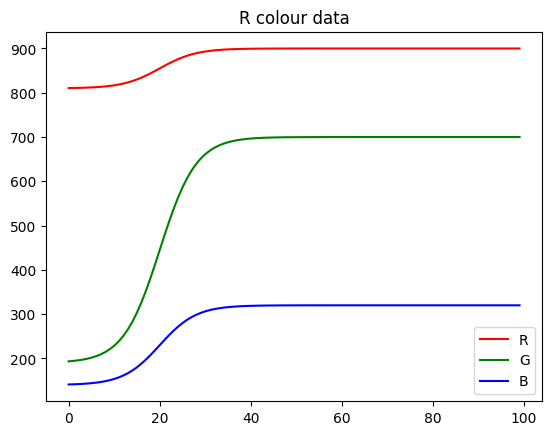

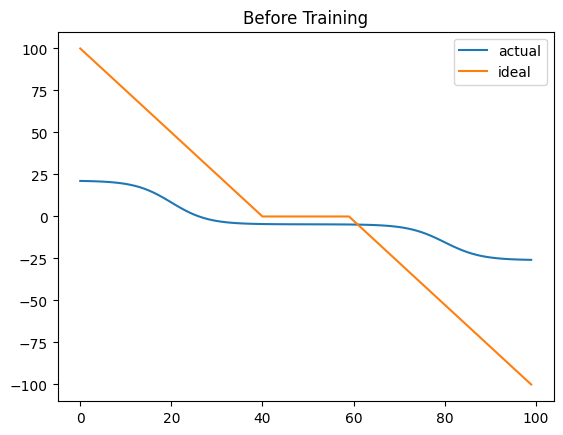

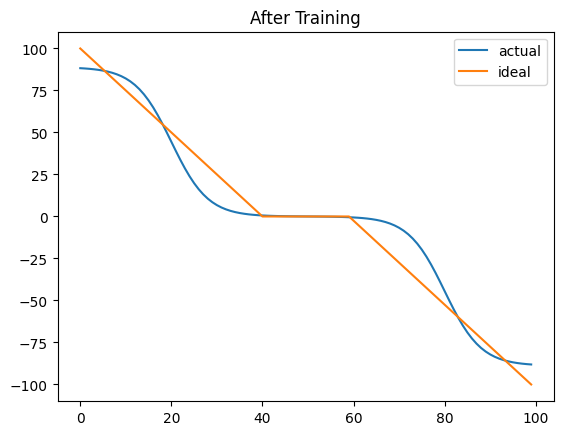

In [984]:
def train():
    plot_cols = ["r", "g", "b"]

    dfs = input_data()
    l_df = dfs[1]
    r_df = dfs[0]
    l_df.plot(title="L colour data", color=plot_cols)
    r_df.plot(title="R colour data", color=plot_cols)

    print(f"Weights before training: {weights}")

    steer_vals_untrained = lf_algorithm_steers(weights, l_df, r_df)
    ideal = ideal_steer()
    e = error(lf_algorithm_steers(weights, l_df, r_df), ideal)
    print(f"Error before training: {e}")
    plot_df = pd.DataFrame({"actual": steer_vals_untrained, "ideal": ideal})
    plot_df.plot(title="Before Training")

    for i in range(TRAIN_ITERATIONS):
        gradient = calc_gradient(weights, l_df, r_df, ideal)
        for j in range(len(weights)):
            weights[j] += gradient[j]

    print(f"Weights after training: {weights}")
    e = error(lf_algorithm_steers(weights, l_df, r_df), ideal)
    print(f"Error after training: {e}")
    steer_vals_trained = lf_algorithm_steers(weights, l_df, r_df)
    plot_df = pd.DataFrame({"actual": steer_vals_trained, "ideal": ideal})
    plot_df.plot(title="After Training")


train()